In [1]:
import os
import torch
from PIL import Image
import torch.nn as nn
import numpy as np
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from Functions_and_classes import findlabel,psnr,unnormalized_show,getdataset,compset,ARCNN

Initialize model and optimization method

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type=='cuda':
    model = ARCNN().cuda()
else:
    model = ARCNN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
cost = nn.MSELoss()
n_epochs = 30

Loading pre-trained model using video sequences: coastguard, akiyo, news and silent and use this model to further trained with BSDS500 dataset

In [13]:
if device.type=='cuda':
    model.load_state_dict(torch.load("./model_parameter.pkl"))
else:
    model.load_state_dict(torch.load("./model_parameter.pkl",map_location='cpu'))

Training Model

In [4]:
for qScale in np.arange(1.95,0,-0.3):
    Q = 'Q'+'%.2f'%qScale
    train = getdataset(Q,transform)
    data_train = torch.utils.data.DataLoader(dataset=train, batch_size = 10, shuffle = True)
    for epoch in range(n_epochs):
            running_loss = 0.0
            running_correct = 0
            print("Epoch {}/{}".format(epoch, n_epochs))
            print("-"*10)
            for data in data_train:
                X_train, y_train = data
                if device.type=='cuda':
                    X_train, y_train = Variable(X_train).cuda(), Variable(y_train).cuda()
                else:
                    X_train, y_train = Variable(X_train), Variable(y_train)
                outputs = model(X_train)
                loss = cost(outputs, y_train)
                optimizer.zero_grad()

                loss.backward()
                optimizer.step()
                running_loss += loss.data
                #running_correct += torch.sum(pred == y_train.data)

            print("Loss is:{:.8f}".format(running_loss/len(data_train)))
                                                                                          

Epoch 0/20
----------
Loss is:0.14133595
Epoch 1/20
----------
Loss is:0.06548655
Epoch 2/20
----------
Loss is:0.05715711
Epoch 3/20
----------
Loss is:0.05720363
Epoch 4/20
----------
Loss is:0.05380056
Epoch 5/20
----------
Loss is:0.04014781
Epoch 6/20
----------
Loss is:0.02753269
Epoch 7/20
----------
Loss is:0.02369552
Epoch 8/20
----------
Loss is:0.02194499
Epoch 9/20
----------
Loss is:0.01884960
Epoch 10/20
----------
Loss is:0.01750609
Epoch 11/20
----------
Loss is:0.01664052
Epoch 12/20
----------
Loss is:0.01563457
Epoch 13/20
----------
Loss is:0.01480935
Epoch 14/20
----------
Loss is:0.01438636
Epoch 15/20
----------
Loss is:0.01393700
Epoch 16/20
----------
Loss is:0.01381973
Epoch 17/20
----------
Loss is:0.01340442
Epoch 18/20
----------
Loss is:0.01324144
Epoch 19/20
----------
Loss is:0.01343480
Epoch 0/20
----------
Loss is:0.01412522
Epoch 1/20
----------
Loss is:0.01278544
Epoch 2/20
----------
Loss is:0.01179196
Epoch 3/20
----------
Loss is:0.01134090
Epoch 

Save the model you train

In [5]:
#torch.save(model.state_dict(), "./low2high.pkl")

Load already trained model

In [3]:
if device.type=='cuda':
    model.load_state_dict(torch.load("./low2high.pkl"))
else:
    model.load_state_dict(torch.load("./low2high.pkl",map_location='cpu'))

Test the PSNR of the test Video

In [4]:
featpath = './train_feature/'
labelpath = './train_label/'
foreman = 'foreman20_40_RGB/'

j = 0;
PSNR_test = np.zeros([21,7])
PSNR_original = np.zeros([21,7])
for qScale in np.arange(0.15,2,0.3):
    Q = 'Q'+'%.2f'%qScale
    test = compset(os.path.join(featpath ,foreman,Q),os.path.join(labelpath,foreman),transform)
    data_test = torch.utils.data.DataLoader(dataset=test, batch_size = 1, shuffle = False)
    i = 0
    for X,Y in data_test:
        if device.type=='cuda':
            X = Variable(X).cuda()
        else:
            X = Variable(X)
        Y_rec = model(X)
        pic = unnormalized_show(Y_rec.cpu())
        pic = pic[:,:,:,0]
        Y = unnormalized_show(Y)
        Y = Y[:,:,:,0]
        X = unnormalized_show(X.cpu())
        X = X[:,:,:,0]
        PSNR_test[i,j] = psnr(pic,Y)
        PSNR_original[i,j] = psnr(X,Y)
        i = i+1
    j = j+1
print(np.mean(PSNR_test,0)) #the result after ARCNN
print(np.mean(PSNR_original,0)) #the result without ARCNN

[39.24122282 37.1089672  35.78697705 34.84181023 34.12119539 33.52920296
 33.04901247]
[40.05838696 35.84850501 34.34592879 33.39993262 32.72285268 32.1696793
 31.70518187]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


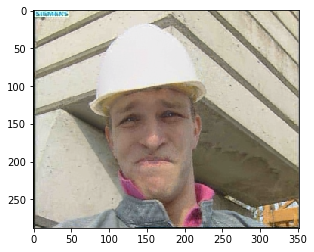

In [5]:
plt.imshow(pic)